# Chatbot

Options :

In [1]:
train_model = True
#train_model = False

api = False
#api = True

#test = False
test = True

Importer les modules nécessaires :

In [2]:
from connecteur import Connecteur

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer, EnglishStemmer

import numpy as np

import pandas as pd

import pickle

import re

import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from textblob import TextBlob

import unicodedata

Obtenir la DataFrame à partir de la base MongoDB :

In [3]:
data1 = Connecteur.get_all_data()

#créer les listes vides
tags = []
inputs = []
responses={}
#les remplir avec le contenu du JSON
for intent in data1['intents']:
  responses[intent['tag']]=intent['liste_output']
  for lines in intent['liste_input']:
    inputs.append(lines)
    tags.append(intent['tag'])
    
#convertir en DataFrame
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

Séparer la DataFrame en tags françaises et anglaises, puis les mélanger :

In [4]:
en_data = data[data["tags"].str.startswith("en_")]
fr_data = data[~data["tags"].str.startswith("en_")]

#mélanger aléatoirement
en_data = en_data.sample(frac=1)
fr_data = fr_data.sample(frac=1)

en_list_name = en_data["tags"].value_counts().index.tolist()
en_list_number = en_data["tags"].value_counts().tolist()
en_list = list(zip(en_list_name, en_list_number))

fr_list_name = fr_data["tags"].value_counts().index.tolist()
fr_list_number = fr_data["tags"].value_counts().tolist()
fr_list = list(zip(fr_list_name, fr_list_number))

#montrer les DataFrames et leurs catégories
display(en_data)
display(fr_data)

,inputs,tags
892,Are there special measures in place against CO...,en_covid
1580,Can an employee join the formation?,en_salarie
980,How do we pass the formation?,en_evaluation
1289,Can I choose my interns?,en_choix_alternant
936,Are there financial aids?,en_aide financiere
...,...,...
891,Are the students protected against COVID?,en_covid
1683,Do I have to drive?,en_permis
1169,What are the technologies studied?,en_techs
1590,Can someone with a job still join the formation?,en_salarie


,inputs,tags
420,Comment est-on noté ?,evaluation
470,Et après la formation ?,debouches
328,Titre,titre
90,Étudiant en Data,apprenant
427,évaluation ?,evaluation
...,...,...
393,Quels enseignants auront les élèves ?,enseignants
336,La formation nous qualifie pour quel titre ?,titre
425,Examens ?,evaluation
475,Taux de réussite ?,debouches


In [5]:
display("tags en anglais:", len(en_list))
display(en_list)
display("tags en français:", len(fr_list))
display(fr_list)

'tags en anglais:'

42

[('en_covid', 41),
 ('en_aide financiere', 37),
 ('en_apprenant', 36),
 ('en_negation', 35),
 ('en_code', 34),
 ('en_partner', 32),
 ('en_titre', 32),
 ('en_salutation', 32),
 ('en_affirmation', 31),
 ('en_admission', 31),
 ('en_evaluation', 30),
 ('en_techs', 30),
 ('en_alternance', 29),
 ('en_pédagogie', 28),
 ('en_debouches', 27),
 ('en_pas_demandeur', 26),
 ('en_contrat', 26),
 ('en_structure', 26),
 ('en_cout_partenaire', 26),
 ('en_fin', 25),
 ('en_conditions', 25),
 ('en_selection', 23),
 ('en_materiel', 23),
 ('en_date', 22),
 ('en_sujet', 22),
 ('en_tuteur', 21),
 ('en_contacts', 21),
 ('en_postes', 21),
 ('en_logement', 21),
 ('en_niveau_fin', 21),
 ('en_choix_alternant', 20),
 ('en_enseignants', 20),
 ('en_competences', 19),
 ('en_nombre_recruter', 18),
 ('en_salarie', 17),
 ('en_nombre_promo', 17),
 ('en_contribution', 17),
 ('en_insultes', 16),
 ('en_personne', 15),
 ('en_suivi', 15),
 ('en_permis', 15),
 ('en_adresser', 12)]

'tags en français:'

42

[('debouches', 47),
 ('apprenant', 47),
 ('admission', 42),
 ('partenaire', 38),
 ('covid', 36),
 ('alternance', 33),
 ('code', 32),
 ('evaluation ', 31),
 ('pédagogie', 31),
 ('enseignants', 30),
 ('salutation', 27),
 ('titre', 27),
 ('fin', 26),
 ('tuteur', 25),
 ('affirmation', 24),
 ('date', 23),
 ('nombre_recruter', 22),
 ('postes', 21),
 ('permis', 21),
 ('negation', 20),
 ('adresser', 15),
 ('logement', 13),
 ('materiel', 12),
 ('niveau_fin', 11),
 ('sujet', 9),
 ('aide financiere', 6),
 ('insultes', 5),
 ('suivi', 4),
 ('compétences', 2),
 ('contribution', 1),
 ('personne', 1),
 ('structure', 1),
 ('techs', 1),
 ('nombre_promo', 1),
 ('pas_demandeur', 1),
 ('selection', 1),
 ('contrat', 1),
 ('contacts', 1),
 ('choix_alternant', 1),
 ('conditions ', 1),
 ('cout_partenaire', 1),
 ('salarie', 1)]

Créer les fonctions de traitement du texte :

In [6]:
#enlever les accents du texte
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return str(only_ascii)[2:-1]

In [7]:
#définir les stopwords
stop_words_en = list(set(stopwords.words('english')))
stop_words_fr = list(set(stopwords.words('french')))

#rajouter aux stopwords français leurs versions sans accents
stop_words_fr_1 = []
for word in stop_words_fr:
    word = remove_accents(word)
    stop_words_fr_1.append(word)
stop_words_fr = list(sorted(set(stop_words_fr + stop_words_fr_1)))

In [8]:
def english_or_french(text):
    #vérifier la langue
    fr_score = 0
    en_score = 0
    detect_list = []
    for word in text.split():
        word = re.sub(r'\W+', '', word)
        if word != "":
            word = TextBlob(word + " " + word + " " + word)
            detected = word.detect_language()
            detect_list.append(detected)
    for language in detect_list:
        if language == "fr":
            fr_score += 1
        elif language == "en":
            en_score += 1
    if en_score > fr_score:
        language = "anglais"
    else:
        language = "francais"
    return language

In [9]:
#traiter le texte
def treatment(text, language):
    #vérifier si c'est une question
    if text[-1] == "?":
        question = "?"
    else:
        question = "0"
        
    #vérifier la langue
    if language == None:
        language = english_or_french(text)
    
    #segmenter le texte et traiter chaque mot et chaque lettre
    text = text.split()
    words_list = []
    for word in text:
        letters_list = []
        for character in word:
            #vérifier que le caractère est une lettre
            if character.isalpha():
                #rajouter à la liste en minuscule
                letters_list.append(character.lower())
            else:
                letters_list.append(" ")
        word = "".join(letters_list)
        
        #appliquer le stemming suivant la langue
        for word1 in word.split():
            word_yes = False
            if language == "anglais":
                if word1 not in stop_words_en:
                    word1 = EnglishStemmer().stem(word1)
                    word_yes = True
            else:
                if word1 not in stop_words_fr:
                    word1 = FrenchStemmer().stem(word1)
                    word_yes = True
            #enlever les accents
            if word_yes == True:
                word1 = remove_accents(word1)
                words_list.append(word1)
            
    #joindre en une string
    text = " ".join(words_list)
    return " ".join([text, question, language])
    #pour avoir en trois colonnes
    #return [text, question, language]

Obtenir une colonne avec les inputs traités :

In [10]:
#pour avoir en trois colonnes

#text_list = []
#ques_list = []
#lang_list = []

#for value in data["inputs"]:
    #value = treatment(value)
    #text_list.append(value[0])
    #ques_list.append(value[1])
    #lang_list.append(value[2])

#data["text"] = text_list
#data["?"] = ques_list
#data["language"] = lang_list

In [11]:
list_en_text = []
for value in en_data["inputs"]:
    value = treatment(value, language="anglais")
    list_en_text.append(value)
    
list_fr_text = []
for value in fr_data["inputs"]:
    value = treatment(value, language="francais")
    list_fr_text.append(value)

en_data["texts"] = list_en_text
fr_data["texts"] = list_fr_text

display(en_data, fr_data)

,inputs,tags,texts
892,Are there special measures in place against CO...,en_covid,special measur place covid ? anglais
1580,Can an employee join the formation?,en_salarie,employe join format ? anglais
980,How do we pass the formation?,en_evaluation,pass format ? anglais
1289,Can I choose my interns?,en_choix_alternant,choos intern ? anglais
936,Are there financial aids?,en_aide financiere,financi aid ? anglais
...,...,...,...
891,Are the students protected against COVID?,en_covid,student protect covid ? anglais
1683,Do I have to drive?,en_permis,drive ? anglais
1169,What are the technologies studied?,en_techs,technolog studi ? anglais
1590,Can someone with a job still join the formation?,en_salarie,someon job still join format ? anglais


,inputs,tags,texts
420,Comment est-on noté ?,evaluation,comment not ? francais
470,Et après la formation ?,debouches,apres format ? francais
328,Titre,titre,titr 0 francais
90,Étudiant en Data,apprenant,etudi dat 0 francais
427,évaluation ?,evaluation,evalu ? francais
...,...,...,...
393,Quels enseignants auront les élèves ?,enseignants,quel enseign elev ? francais
336,La formation nous qualifie pour quel titre ?,titre,format qualif quel titr ? francais
425,Examens ?,evaluation,examen ? francais
475,Taux de réussite ?,debouches,taux reussit ? francais


Appliquer le tokenizer sur les inputs traités :

In [12]:
en_tokenizer = Tokenizer(num_words=2000)
en_tokenizer.fit_on_texts(en_data['texts'])
with open('en_tokenizer.pickle', 'wb') as handle:
    pickle.dump(en_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

en_x = en_tokenizer.texts_to_sequences(en_data['texts'])
#appliquer le padding
en_x = pad_sequences(en_x)

fr_tokenizer = Tokenizer(num_words=2000)
fr_tokenizer.fit_on_texts(fr_data['texts'])
with open('fr_tokenizer.pickle', 'wb') as handle:
    pickle.dump(fr_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

fr_x = fr_tokenizer.texts_to_sequences(fr_data['texts'])
#appliquer le padding
fr_x = pad_sequences(fr_x)

Appliquer LabelEncoder sur les tags et obtenir la cible :

In [13]:
en_le = LabelEncoder()
en_y = en_le.fit_transform(en_data['tags'])

fr_le = LabelEncoder()
fr_y = fr_le.fit_transform(fr_data['tags'])

Obtenir la shape des inputs :

In [14]:
en_input_shape = en_x.shape[1]
print(en_input_shape)

fr_input_shape = fr_x.shape[1]
print(fr_input_shape)

9
12


Obtenir le vocabulaire :

In [15]:
en_vocabulary = len(en_tokenizer.word_index)
print("Nombre de mots uniques anglais : ",en_vocabulary)
en_output_length = en_le.classes_.shape[0]
print("Taille des outputs anglais : ", en_output_length)

fr_vocabulary = len(fr_tokenizer.word_index)
print("Nombre de mots uniques français : ",fr_vocabulary)
fr_output_length = fr_le.classes_.shape[0]
print("Taille des outputs français : ", fr_output_length)

Nombre de mots uniques anglais :  322
Taille des outputs anglais :  42
Nombre de mots uniques français :  410
Taille des outputs français :  42


## Modèle

Séparer ``x`` et ``y`` en ``train`` et ``val`` pour la validation :

In [16]:
#longueur d'1/5 du Dataset
en_prod=int(len(en_x)* 0.2)
fr_prod=int(len(fr_x)* 0.2)

#séparation en x_val et x_train
en_x_val=en_x[-en_prod:, :]
en_x_train=en_x[:-en_prod, :]
fr_x_val=fr_x[-fr_prod:, :]
fr_x_train=fr_x[:-fr_prod, :]

In [17]:
#séparation en y_val et y_train
en_y_val=en_y[ -en_prod:]
en_y_train=en_y[:-en_prod]
fr_y_val=fr_y[ -fr_prod:]
fr_y_train=fr_y[:-fr_prod]

In [18]:
print("en_x_val", en_x_val.shape)
print("en_x_train", en_x_train.shape)
print("en_y_val", en_y_val.shape)
print("en_y_train", en_y_train.shape)
print("fr_x_val", fr_x_val.shape)
print("fr_x_train", fr_x_train.shape)
print("fr_y_val", fr_y_val.shape)
print("fr_y_train", fr_y_train.shape)

en_x_val (207, 9)
en_x_train (828, 9)
en_y_val (207,)
en_y_train (828,)
fr_x_val (138, 12)
fr_x_train (555, 12)
fr_y_val (138,)
fr_y_train (555,)


Créer et entraîner le modèle :

In [19]:
if train_model == True:
    #créer le modèle
    i = Input(shape=(en_input_shape,))
    x = Embedding(en_vocabulary+1,10)(i)
    #x = LSTM(10,return_sequences=True)(x)
    x = Bidirectional(LSTM(10, return_sequences=True), input_shape=(5, 10))(x)
    x = Bidirectional(LSTM(10))(x)
    x = Flatten()(x)
    x = Dense(en_output_length,activation="softmax")(x)
    en_model  = Model(i,x)

    #compiler le modèle
    en_model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

    #enregistrer le modèle à son meilleur résultat
    en_model_name = "model_py/en_model.h5"

    en_modelcheckpoint = ModelCheckpoint(en_model_name,
                                      monitor='val_loss',
                                      mode='auto',
                                      verbose=1,
                                      save_best_only=True)
    
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                     factor=0.5,
                                     patience=7,
                                     min_lr=1e-7,
                                     verbose=1)

    en_callback_list = [en_modelcheckpoint, lr_scheduler]
    
    #entraîner le modèle
    en_history = en_model.fit(en_x_train,en_y_train,epochs=200,
                              validation_data=(en_x_val, en_y_val),
                              callbacks=en_callback_list)
    clear_session()

Epoch 1/200
24/26 [==========================>...] - ETA: 0s - loss: 3.7367 - accuracy: 0.0286
Epoch 00001: val_loss improved from inf to 3.73260, saving model to model_py\en_model.h5
26/26 [==============================] - 7s 262ms/step - loss: 3.7365 - accuracy: 0.0266 - val_loss: 3.7326 - val_accuracy: 0.0145
Epoch 2/200
25/26 [===========================>..] - ETA: 0s - loss: 3.7290 - accuracy: 0.0487
Epoch 00002: val_loss improved from 3.73260 to 3.72302, saving model to model_py\en_model.h5
26/26 [==============================] - 1s 27ms/step - loss: 3.7290 - accuracy: 0.0519 - val_loss: 3.7230 - val_accuracy: 0.0435
Epoch 3/200
25/26 [===========================>..] - ETA: 0s - loss: 3.7156 - accuracy: 0.0662
Epoch 00003: val_loss improved from 3.72302 to 3.69957, saving model to model_py\en_model.h5
26/26 [==============================] - 1s 35ms/step - loss: 3.7145 - accuracy: 0.0664 - val_loss: 3.6996 - val_accuracy: 0.0435
Epoch 4/200
26/26 [==============================

26/26 [==============================] - ETA: 0s - loss: 1.2121 - accuracy: 0.7729
Epoch 00026: val_loss improved from 1.69918 to 1.62357, saving model to model_py\en_model.h5
26/26 [==============================] - 1s 38ms/step - loss: 1.2121 - accuracy: 0.7729 - val_loss: 1.6236 - val_accuracy: 0.5894
Epoch 27/200
24/26 [==========================>...] - ETA: 0s - loss: 1.1698 - accuracy: 0.7852
Epoch 00027: val_loss improved from 1.62357 to 1.59814, saving model to model_py\en_model.h5
26/26 [==============================] - 1s 37ms/step - loss: 1.1696 - accuracy: 0.7838 - val_loss: 1.5981 - val_accuracy: 0.5894
Epoch 28/200
26/26 [==============================] - ETA: 0s - loss: 1.1279 - accuracy: 0.7923
Epoch 00028: val_loss improved from 1.59814 to 1.58145, saving model to model_py\en_model.h5
26/26 [==============================] - 1s 39ms/step - loss: 1.1279 - accuracy: 0.7923 - val_loss: 1.5814 - val_accuracy: 0.5845
Epoch 29/200
25/26 [===========================>..] - ET

26/26 [==============================] - 1s 34ms/step - loss: 0.6576 - accuracy: 0.8768 - val_loss: 1.1738 - val_accuracy: 0.6957
Epoch 53/200
26/26 [==============================] - ETA: 0s - loss: 0.6327 - accuracy: 0.8768
Epoch 00053: val_loss improved from 1.15579 to 1.12909, saving model to model_py\en_model.h5
26/26 [==============================] - 1s 36ms/step - loss: 0.6327 - accuracy: 0.8768 - val_loss: 1.1291 - val_accuracy: 0.7246
Epoch 54/200
25/26 [===========================>..] - ETA: 0s - loss: 0.5683 - accuracy: 0.9000
Epoch 00054: val_loss did not improve from 1.12909
26/26 [==============================] - 1s 29ms/step - loss: 0.5677 - accuracy: 0.8986 - val_loss: 1.1435 - val_accuracy: 0.7150
Epoch 55/200
25/26 [===========================>..] - ETA: 0s - loss: 0.5657 - accuracy: 0.8988
Epoch 00055: val_loss did not improve from 1.12909
26/26 [==============================] - 1s 35ms/step - loss: 0.5592 - accuracy: 0.9010 - val_loss: 1.1383 - val_accuracy: 0.71

Epoch 81/200
25/26 [===========================>..] - ETA: 0s - loss: 0.3506 - accuracy: 0.9388
Epoch 00081: val_loss did not improve from 1.04184
26/26 [==============================] - 2s 58ms/step - loss: 0.3538 - accuracy: 0.9372 - val_loss: 1.0461 - val_accuracy: 0.7488
Epoch 82/200
26/26 [==============================] - ETA: 0s - loss: 0.3508 - accuracy: 0.9408 ETA: 0s - loss: 0.3515 - accuracy: 0.94
Epoch 00082: val_loss improved from 1.04184 to 1.03837, saving model to model_py\en_model.h5
26/26 [==============================] - 2s 64ms/step - loss: 0.3508 - accuracy: 0.9408 - val_loss: 1.0384 - val_accuracy: 0.7536
Epoch 83/200
25/26 [===========================>..] - ETA: 0s - loss: 0.3428 - accuracy: 0.9413
Epoch 00083: val_loss did not improve from 1.03837
26/26 [==============================] - 1s 44ms/step - loss: 0.3446 - accuracy: 0.9408 - val_loss: 1.0490 - val_accuracy: 0.7585
Epoch 84/200
25/26 [===========================>..] - ETA: 0s - loss: 0.3528 - accuracy

25/26 [===========================>..] - ETA: 0s - loss: 0.2820 - accuracy: 0.9513 ETA: 0s - loss: 0.2776 - accuracy: 0.95
Epoch 00109: val_loss did not improve from 0.99483

Epoch 00109: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
26/26 [==============================] - 1s 30ms/step - loss: 0.2774 - accuracy: 0.9529 - val_loss: 1.0578 - val_accuracy: 0.7295
Epoch 110/200
26/26 [==============================] - ETA: 0s - loss: 0.2780 - accuracy: 0.9577
Epoch 00110: val_loss did not improve from 0.99483
26/26 [==============================] - 1s 27ms/step - loss: 0.2780 - accuracy: 0.9577 - val_loss: 0.9981 - val_accuracy: 0.7585
Epoch 111/200
25/26 [===========================>..] - ETA: 0s - loss: 0.2597 - accuracy: 0.9613
Epoch 00111: val_loss did not improve from 0.99483
26/26 [==============================] - 1s 30ms/step - loss: 0.2664 - accuracy: 0.9589 - val_loss: 1.0149 - val_accuracy: 0.7536
Epoch 112/200
25/26 [===========================>..] - ETA:

Epoch 137/200
26/26 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.9626
Epoch 00137: val_loss did not improve from 0.99483

Epoch 00137: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
26/26 [==============================] - 1s 25ms/step - loss: 0.2405 - accuracy: 0.9626 - val_loss: 1.0196 - val_accuracy: 0.7633
Epoch 138/200
25/26 [===========================>..] - ETA: 0s - loss: 0.2381 - accuracy: 0.9650
Epoch 00138: val_loss did not improve from 0.99483
26/26 [==============================] - 1s 26ms/step - loss: 0.2402 - accuracy: 0.9638 - val_loss: 1.0175 - val_accuracy: 0.7633
Epoch 139/200
25/26 [===========================>..] - ETA: 0s - loss: 0.2428 - accuracy: 0.9625
Epoch 00139: val_loss did not improve from 0.99483
26/26 [==============================] - 1s 26ms/step - loss: 0.2401 - accuracy: 0.9638 - val_loss: 1.0178 - val_accuracy: 0.7585
Epoch 140/200
26/26 [==============================] - ETA: 0s - loss: 0.2400 - accu

Epoch 165/200
26/26 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9638
Epoch 00165: val_loss did not improve from 0.99483

Epoch 00165: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
26/26 [==============================] - 1s 51ms/step - loss: 0.2389 - accuracy: 0.9638 - val_loss: 1.0173 - val_accuracy: 0.7633
Epoch 166/200
25/26 [===========================>..] - ETA: 0s - loss: 0.2390 - accuracy: 0.9638
Epoch 00166: val_loss did not improve from 0.99483
26/26 [==============================] - 2s 67ms/step - loss: 0.2389 - accuracy: 0.9638 - val_loss: 1.0173 - val_accuracy: 0.7633
Epoch 167/200
26/26 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9638
Epoch 00167: val_loss did not improve from 0.99483
26/26 [==============================] - 1s 53ms/step - loss: 0.2389 - accuracy: 0.9638 - val_loss: 1.0173 - val_accuracy: 0.7633
Epoch 168/200
25/26 [===========================>..] - ETA: 0s - loss: 0.2402 - accur

25/26 [===========================>..] - ETA: 0s - loss: 0.2358 - accuracy: 0.9638
Epoch 00193: val_loss did not improve from 0.99483

Epoch 00193: ReduceLROnPlateau reducing learning rate to 1e-07.
26/26 [==============================] - 1s 27ms/step - loss: 0.2388 - accuracy: 0.9638 - val_loss: 1.0174 - val_accuracy: 0.7633
Epoch 194/200
26/26 [==============================] - ETA: 0s - loss: 0.2388 - accuracy: 0.9638
Epoch 00194: val_loss did not improve from 0.99483
26/26 [==============================] - 1s 27ms/step - loss: 0.2388 - accuracy: 0.9638 - val_loss: 1.0174 - val_accuracy: 0.7633
Epoch 195/200
25/26 [===========================>..] - ETA: 0s - loss: 0.2411 - accuracy: 0.9625
Epoch 00195: val_loss did not improve from 0.99483
26/26 [==============================] - 1s 29ms/step - loss: 0.2388 - accuracy: 0.9638 - val_loss: 1.0173 - val_accuracy: 0.7633
Epoch 196/200
24/26 [==========================>...] - ETA: 0s - loss: 0.2378 - accuracy: 0.9648
Epoch 00196: val_l

In [20]:
if train_model == True:
    #créer le modèle
    i = Input(shape=(fr_input_shape,))
    x = Embedding(fr_vocabulary+1,10)(i)
    #x = LSTM(10,return_sequences=True)(x)
    x = Bidirectional(LSTM(10, return_sequences=True), input_shape=(5, 10))(x)
    x = Bidirectional(LSTM(10))(x)
    x = Flatten()(x)
    x = Dense(fr_output_length,activation="softmax")(x)
    fr_model  = Model(i,x)

    #compiler le modèle
    fr_model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

    #enregistrer le modèle à son meilleur résultat
    fr_model_name = "model_py/fr_model.h5"

    fr_modelcheckpoint = ModelCheckpoint(fr_model_name,
                                      monitor='val_loss',
                                      mode='auto',
                                      verbose=1,
                                      save_best_only=True)
    
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                     factor=0.5,
                                     patience=7,
                                     min_lr=1e-7,
                                     verbose=1)

    fr_callback_list = [fr_modelcheckpoint, lr_scheduler]
    
    #entraîner le modèle
    fr_history = fr_model.fit(fr_x_train,fr_y_train,epochs=200,
                              validation_data=(fr_x_val, fr_y_val),
                              callbacks=fr_callback_list)
    clear_session()

Epoch 1/200
17/18 [===========================>..] - ETA: 0s - loss: 3.7283 - accuracy: 0.0515
Epoch 00001: val_loss improved from inf to 3.71648, saving model to model_py\fr_model.h5
18/18 [==============================] - 7s 393ms/step - loss: 3.7280 - accuracy: 0.0523 - val_loss: 3.7165 - val_accuracy: 0.0290
Epoch 2/200
17/18 [===========================>..] - ETA: 0s - loss: 3.6918 - accuracy: 0.0570
Epoch 00002: val_loss improved from 3.71648 to 3.67252, saving model to model_py\fr_model.h5
18/18 [==============================] - 1s 37ms/step - loss: 3.6912 - accuracy: 0.0577 - val_loss: 3.6725 - val_accuracy: 0.0290
Epoch 3/200
17/18 [===========================>..] - ETA: 0s - loss: 3.5960 - accuracy: 0.0570
Epoch 00003: val_loss improved from 3.67252 to 3.55394, saving model to model_py\fr_model.h5
18/18 [==============================] - 1s 39ms/step - loss: 3.5936 - accuracy: 0.0577 - val_loss: 3.5539 - val_accuracy: 0.0290
Epoch 4/200
18/18 [==============================

Epoch 27/200
18/18 [==============================] - ETA: 0s - loss: 1.5986 - accuracy: 0.6144
Epoch 00027: val_loss improved from 2.14453 to 2.10184, saving model to model_py\fr_model.h5
18/18 [==============================] - 1s 39ms/step - loss: 1.5986 - accuracy: 0.6144 - val_loss: 2.1018 - val_accuracy: 0.4710
Epoch 28/200
18/18 [==============================] - ETA: 0s - loss: 1.5253 - accuracy: 0.6198
Epoch 00028: val_loss improved from 2.10184 to 2.10175, saving model to model_py\fr_model.h5
18/18 [==============================] - 1s 39ms/step - loss: 1.5253 - accuracy: 0.6198 - val_loss: 2.1017 - val_accuracy: 0.4710
Epoch 29/200
17/18 [===========================>..] - ETA: 0s - loss: 1.4734 - accuracy: 0.6673
Epoch 00029: val_loss improved from 2.10175 to 2.09060, saving model to model_py\fr_model.h5
18/18 [==============================] - 1s 39ms/step - loss: 1.4752 - accuracy: 0.6667 - val_loss: 2.0906 - val_accuracy: 0.4928
Epoch 30/200
17/18 [=======================

18/18 [==============================] - ETA: 0s - loss: 0.5734 - accuracy: 0.9207
Epoch 00054: val_loss did not improve from 1.57869
18/18 [==============================] - 1s 39ms/step - loss: 0.5734 - accuracy: 0.9207 - val_loss: 1.7259 - val_accuracy: 0.6159
Epoch 55/200
17/18 [===========================>..] - ETA: 0s - loss: 0.5444 - accuracy: 0.9357
Epoch 00055: val_loss did not improve from 1.57869
18/18 [==============================] - 1s 35ms/step - loss: 0.5496 - accuracy: 0.9351 - val_loss: 1.6437 - val_accuracy: 0.6594
Epoch 56/200
17/18 [===========================>..] - ETA: 0s - loss: 0.5307 - accuracy: 0.9375
Epoch 00056: val_loss did not improve from 1.57869
18/18 [==============================] - 1s 33ms/step - loss: 0.5348 - accuracy: 0.9369 - val_loss: 1.6720 - val_accuracy: 0.6304
Epoch 57/200
17/18 [===========================>..] - ETA: 0s - loss: 0.5133 - accuracy: 0.9375
Epoch 00057: val_loss did not improve from 1.57869
18/18 [============================

17/18 [===========================>..] - ETA: 0s - loss: 0.3569 - accuracy: 0.9540
Epoch 00082: val_loss did not improve from 1.53183
18/18 [==============================] - 1s 33ms/step - loss: 0.3601 - accuracy: 0.9532 - val_loss: 1.5999 - val_accuracy: 0.6957
Epoch 83/200
17/18 [===========================>..] - ETA: 0s - loss: 0.3561 - accuracy: 0.9540
Epoch 00083: val_loss did not improve from 1.53183
18/18 [==============================] - 1s 40ms/step - loss: 0.3585 - accuracy: 0.9532 - val_loss: 1.6075 - val_accuracy: 0.6957
Epoch 84/200
17/18 [===========================>..] - ETA: 0s - loss: 0.3561 - accuracy: 0.9522
Epoch 00084: val_loss did not improve from 1.53183
18/18 [==============================] - 1s 37ms/step - loss: 0.3572 - accuracy: 0.9532 - val_loss: 1.6028 - val_accuracy: 0.6957
Epoch 85/200
17/18 [===========================>..] - ETA: 0s - loss: 0.3561 - accuracy: 0.9540
Epoch 00085: val_loss did not improve from 1.53183
18/18 [============================

18/18 [==============================] - 1s 42ms/step - loss: 0.3446 - accuracy: 0.9550 - val_loss: 1.6064 - val_accuracy: 0.6957
Epoch 111/200
17/18 [===========================>..] - ETA: 0s - loss: 0.3452 - accuracy: 0.9540
Epoch 00111: val_loss did not improve from 1.53183
18/18 [==============================] - 1s 37ms/step - loss: 0.3444 - accuracy: 0.9550 - val_loss: 1.6062 - val_accuracy: 0.6957
Epoch 112/200
18/18 [==============================] - ETA: 0s - loss: 0.3444 - accuracy: 0.9550
Epoch 00112: val_loss did not improve from 1.53183
18/18 [==============================] - 1s 42ms/step - loss: 0.3444 - accuracy: 0.9550 - val_loss: 1.6069 - val_accuracy: 0.6957
Epoch 113/200
18/18 [==============================] - ETA: 0s - loss: 0.3443 - accuracy: 0.9550
Epoch 00113: val_loss did not improve from 1.53183
18/18 [==============================] - 1s 42ms/step - loss: 0.3443 - accuracy: 0.9550 - val_loss: 1.6069 - val_accuracy: 0.6957
Epoch 114/200
18/18 [===============

Epoch 139/200
17/18 [===========================>..] - ETA: 0s - loss: 0.3416 - accuracy: 0.9559
Epoch 00139: val_loss did not improve from 1.53183
18/18 [==============================] - 1s 33ms/step - loss: 0.3434 - accuracy: 0.9550 - val_loss: 1.6076 - val_accuracy: 0.6957
Epoch 140/200
17/18 [===========================>..] - ETA: 0s - loss: 0.3455 - accuracy: 0.9540
Epoch 00140: val_loss did not improve from 1.53183
18/18 [==============================] - 1s 31ms/step - loss: 0.3434 - accuracy: 0.9550 - val_loss: 1.6076 - val_accuracy: 0.6957
Epoch 141/200
17/18 [===========================>..] - ETA: 0s - loss: 0.3468 - accuracy: 0.9540
Epoch 00141: val_loss did not improve from 1.53183
18/18 [==============================] - 1s 34ms/step - loss: 0.3434 - accuracy: 0.9550 - val_loss: 1.6076 - val_accuracy: 0.6957
Epoch 142/200
17/18 [===========================>..] - ETA: 0s - loss: 0.3426 - accuracy: 0.9540
Epoch 00142: val_loss did not improve from 1.53183

Epoch 00142: Redu

17/18 [===========================>..] - ETA: 0s - loss: 0.3456 - accuracy: 0.9540
Epoch 00167: val_loss did not improve from 1.53183
18/18 [==============================] - 1s 41ms/step - loss: 0.3434 - accuracy: 0.9550 - val_loss: 1.6075 - val_accuracy: 0.6957
Epoch 168/200
17/18 [===========================>..] - ETA: 0s - loss: 0.3404 - accuracy: 0.9559
Epoch 00168: val_loss did not improve from 1.53183
18/18 [==============================] - 1s 36ms/step - loss: 0.3434 - accuracy: 0.9550 - val_loss: 1.6075 - val_accuracy: 0.6957
Epoch 169/200
18/18 [==============================] - ETA: 0s - loss: 0.3434 - accuracy: 0.9550
Epoch 00169: val_loss did not improve from 1.53183
18/18 [==============================] - 1s 39ms/step - loss: 0.3434 - accuracy: 0.9550 - val_loss: 1.6075 - val_accuracy: 0.6957
Epoch 170/200
18/18 [==============================] - ETA: 0s - loss: 0.3434 - accuracy: 0.9550
Epoch 00170: val_loss did not improve from 1.53183

Epoch 00170: ReduceLROnPlateau 

18/18 [==============================] - 1s 36ms/step - loss: 0.3433 - accuracy: 0.9550 - val_loss: 1.6076 - val_accuracy: 0.6957
Epoch 196/200
17/18 [===========================>..] - ETA: 0s - loss: 0.3417 - accuracy: 0.9559
Epoch 00196: val_loss did not improve from 1.53183
18/18 [==============================] - 1s 34ms/step - loss: 0.3433 - accuracy: 0.9550 - val_loss: 1.6076 - val_accuracy: 0.6957
Epoch 197/200
17/18 [===========================>..] - ETA: 0s - loss: 0.3456 - accuracy: 0.9540
Epoch 00197: val_loss did not improve from 1.53183
18/18 [==============================] - 1s 35ms/step - loss: 0.3433 - accuracy: 0.9550 - val_loss: 1.6076 - val_accuracy: 0.6957
Epoch 198/200
17/18 [===========================>..] - ETA: 0s - loss: 0.3423 - accuracy: 0.9559
Epoch 00198: val_loss did not improve from 1.53183

Epoch 00198: ReduceLROnPlateau reducing learning rate to 1e-07.
18/18 [==============================] - 1s 36ms/step - loss: 0.3433 - accuracy: 0.9550 - val_loss: 1

## Prédictions

In [21]:
#obtenir les arguments pour chaque ligne
en_y_pred=en_model.predict(en_x_val)
fr_y_pred=fr_model.predict(fr_x_val)

#récupérer l'argument maximal sur chaque ligne
en_y_pred_2 =[]
for pred in en_y_pred:
    en_y_pred_2.append(pred.argmax())
en_y_pred_2 = np.array(en_y_pred_2)
fr_y_pred_2 =[]
for pred in fr_y_pred:
    fr_y_pred_2.append(pred.argmax())
fr_y_pred_2 = np.array(fr_y_pred_2)

Matrice de confusion :

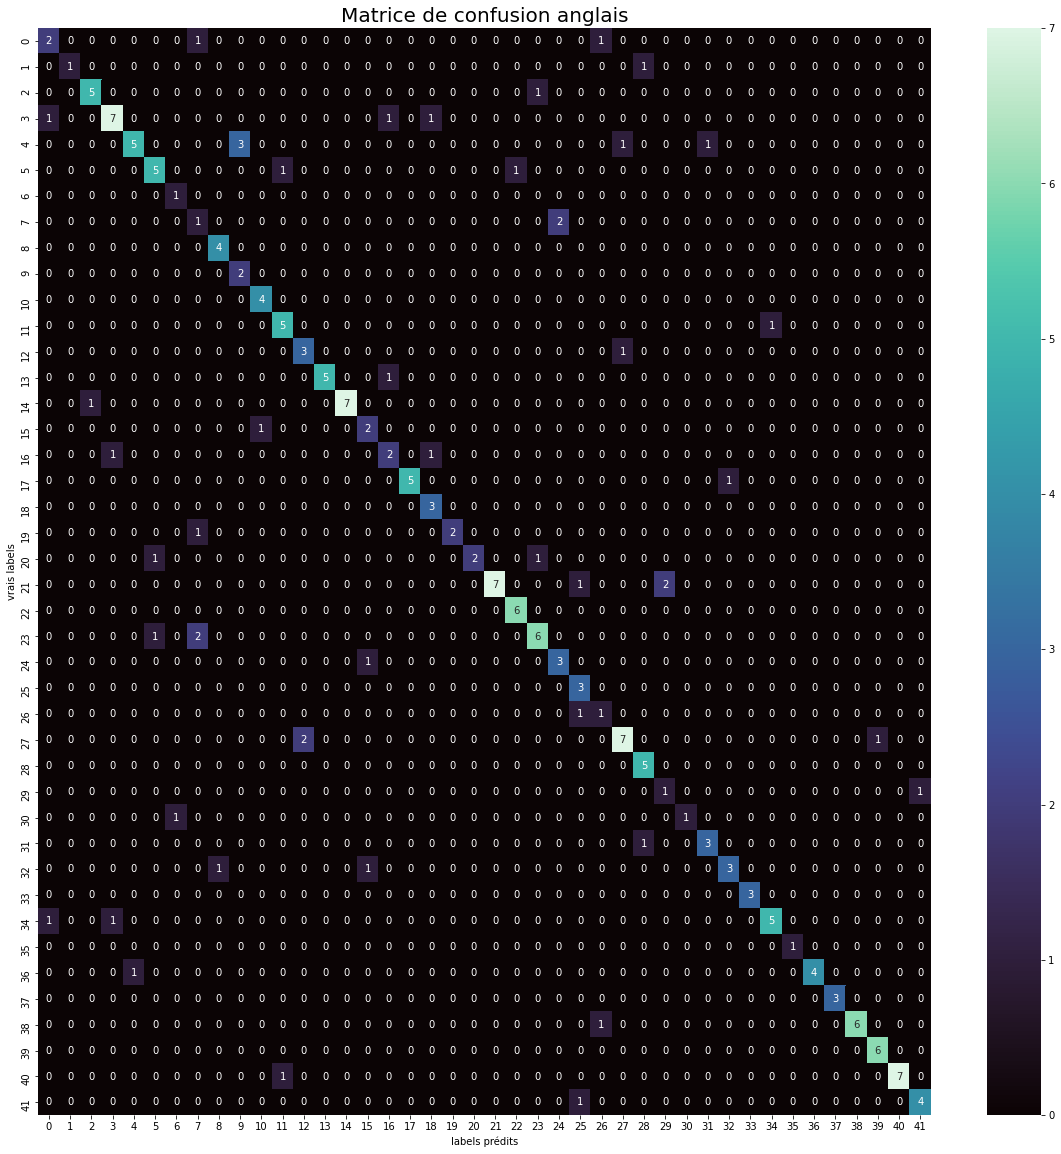

In [23]:
en_cm = confusion_matrix(en_y_val , en_y_pred_2)
plt.figure(figsize=(20,20))
sns.heatmap(en_cm, annot=True, fmt=".0f", cmap = 'mako')
plt.ylabel('vrais labels')
plt.xlabel('labels prédits')
plt.title("Matrice de confusion anglais", size = 20)
plt.show()

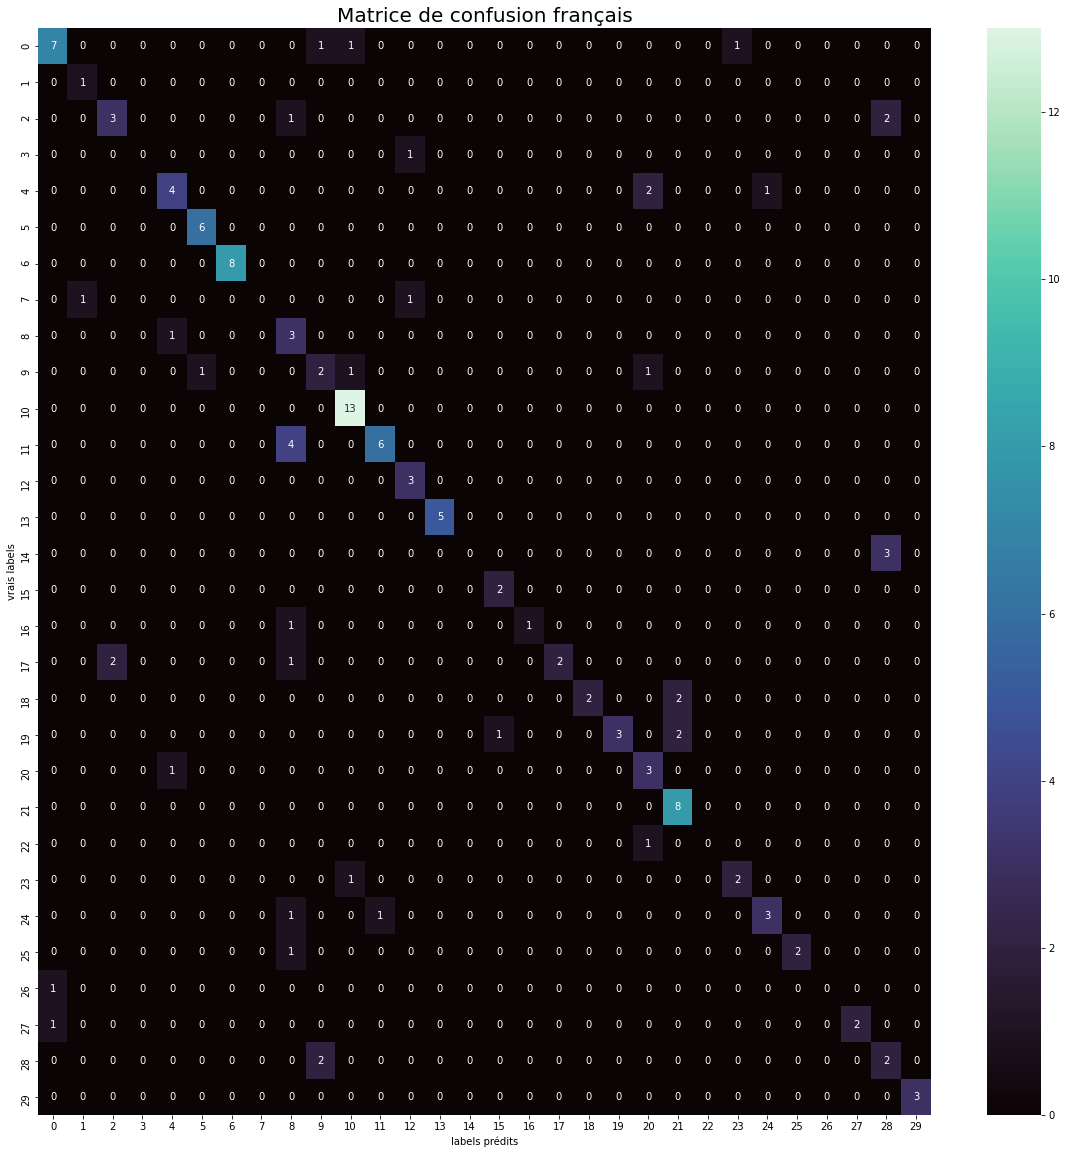

In [24]:
fr_cm = confusion_matrix(fr_y_val , fr_y_pred_2)
plt.figure(figsize=(20,20))
sns.heatmap(fr_cm, annot=True, fmt=".0f", cmap = 'mako')
plt.ylabel('vrais labels')
plt.xlabel('labels prédits')
plt.title("Matrice de confusion français", size = 20)
plt.show()

### Historiques

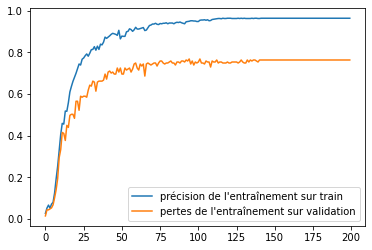

In [25]:
if train_model == True:
    #montrer l'historique de précision et des pertes
    plt.plot(en_history.history['accuracy'],label="précision de l'entraînement sur train")
    plt.plot(en_history.history['val_accuracy'],label="pertes de l'entraînement sur validation")
    plt.legend()

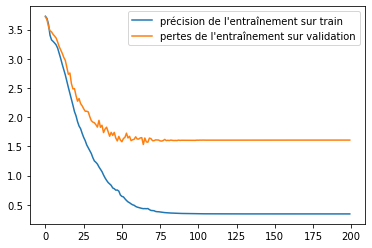

In [26]:
if train_model == True:
    #montrer l'historique de précision et des pertes
    plt.plot(fr_history.history['loss'],label="précision de l'entraînement sur train")
    plt.plot(fr_history.history['val_loss'],label="pertes de l'entraînement sur validation")
    plt.legend()

# Test

In [27]:
if train_model == False:
    en_model = load_model("model_py/en_model.h5")
    fr_model = load_model("model_py/fr_model.h5")

In [28]:
if test == True:
    while True:
        texts_p = []
        prediction_input = input('Vous : ')
        if prediction_input == "0":
            break

        #appliquer la fonction treatment
        prediction_input = treatment(prediction_input, None)
        if prediction_input.split()[-1] == "anglais":
            language = "anglais"
        else:
            language = "francais"
    
        texts_p.append(prediction_input)
        print(prediction_input)

        #tokenizer et padding
        if language == "anglais":
            prediction_input = en_tokenizer.texts_to_sequences(texts_p)
        else:
            prediction_input = fr_tokenizer.texts_to_sequences(texts_p)
        prediction_input = np.array(prediction_input).reshape(-1)
        if language == "anglais":
            prediction_input = pad_sequences([prediction_input],en_input_shape)
        else:
            prediction_input = pad_sequences([prediction_input],fr_input_shape)
        print(prediction_input)

        #obtenir la prédiction du modèle
        if language == "anglais":
            output = en_model.predict(prediction_input)
        else:
            output = fr_model.predict(prediction_input)
        output = output.argmax()
        print(output)

        #trouver la tag correspondante et la réponse
        if language == "anglais":
            response_tag = en_le.inverse_transform([output])[0]
        else:
            response_tag = fr_le.inverse_transform([output])[0]
        print(response_tag)
        #print("Chatbot : ",random.choice(responses[response_tag]))
        if response_tag in ["fin", "en_fin"]:
            break

Vous : Hello.
hello 0 anglais
[[ 0  0  0  0  0  0 56  2  1]]
34
en_salutation
Vous : 0
